# MNIST 实践

In [6]:
# 导入依赖
import os

import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
# 定义超参数
batch_size = 64
learning_rate = 0.01
momentum = 0.5
EPOCH = 10

In [15]:
# 自定义数据集
from PIL import Image
class MnistDataset(Dataset):
  def __init__(self, transform=None, path=None):
    self.path = path
    self.data = os.listdir(self.path)
    self.transform = transform
    self.len = len(self.data)

  def __getitem__(self, index):
    image_index = self.data[index]
    img_path = os.path.join(self.path, image_index)
    img = Image.open(img_path)
    if self.transform:
      img = self.transform(img)

    label = int(image_index[-5])
    # label = self.oneHot(label)
    return img, label

  def __len__(self):
    return self.len

  # 将标签转为onehot编码
  def oneHot(self, label):
    tem = np.zeros(10)
    tem[label] = 1
    return torch.from_numpy(tem)

In [9]:
# 预处理数据集
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# softmax归一化指数函数(https://blog.csdn.net/lz_peter/article/details/84574716),其中0.1307是mean均值和0.3081是std标准差

# 使用 MNIST 数据集
# train_dataset = datasets.MNIST(root='./data/mnist', train=True, transform=transform, download=True)  # 本地没有就加上download=True
# test_dataset = datasets.MNIST(root='./data/mnist', train=False, transform=transform, download=True)  # train=True训练集，=False测试集
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 自定义数据集
train_dataset = MnistDataset(transform=transform, path='./mnist/train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MnistDataset(transform=transform, path='./mnist/test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# fig = plt.figure()
# for i in range(12):
#   plt.subplot(3, 4, i+1)
#   plt.tight_layout()
#   plt.imshow(train_dataset.train_data[i], cmap='gray', interpolation='none')
#   plt.title("Labels: {}".format(train_dataset.train_labels[i]))
#   plt.xticks([])
#   plt.yticks([])
# plt.show()

In [19]:
# 定义网络
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = torch.nn.Sequential(
      torch.nn.Conv2d(1, 10, kernel_size=5),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2),
    )
    self.conv2 = torch.nn.Sequential(
      torch.nn.Conv2d(10, 20, kernel_size=5),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2),
    )
    self.fc = torch.nn.Sequential(
      torch.nn.Linear(320, 50),
      torch.nn.Linear(50, 10),
    )

  def forward(self, x):
    batch_size = x.size(0)
    x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层(图是先卷积后激活再池化，差别不大)
    x = self.conv2(x)  # 再来一次
    x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
    x = self.fc(x)
    return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

model = Net()

In [11]:
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量

In [12]:
# 训练
def train(epoch):
  running_loss = 0.0  # 这整个epoch的loss清零
  running_total = 0
  running_correct = 0
  for batch_idx, data in enumerate(train_loader, 0):
    inputs, target = data
    optimizer.zero_grad()

    # forward + backward + update
    outputs = model(inputs)
    loss = criterion(outputs, target)

    loss.backward()
    optimizer.step()

    # 把运行中的loss累加起来，为了下面300次一除
    running_loss += loss.item()
    # 把运行中的准确率acc算出来
    _, predicted = torch.max(outputs.data, dim=1)
    running_total += inputs.shape[0]
    running_correct += (predicted == target).sum().item()

    if batch_idx % 300 == 299:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
      print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
            % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
      running_loss = 0.0  # 这小批300的loss清零
      running_total = 0
      running_correct = 0  # 这小批300的acc清零

    # torch.save(model.state_dict(), './model_Mnist.pth')
    # torch.save(optimizer.state_dict(), './optimizer_Mnist.pth')

In [13]:
# 测试
def test():
  correct = 0
  total = 0
  with torch.no_grad():  # 测试集不用算梯度
    for data in test_loader:
      images, labels = data
      outputs = model(images)
      _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
      total += labels.size(0)  # 张量之间的比较运算
      correct += (predicted == labels).sum().item()
  acc = correct / total
  print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, EPOCH, 100 * acc))  # 求测试的准确率，正确数/总数
  return acc

[1 / 10]: Accuracy on test set: 68.5 % 
[2 / 10]: Accuracy on test set: 88.6 % 
[3 / 10]: Accuracy on test set: 92.5 % 
[4 / 10]: Accuracy on test set: 92.4 % 
[5 / 10]: Accuracy on test set: 93.4 % 
[6 / 10]: Accuracy on test set: 93.9 % 
[7 / 10]: Accuracy on test set: 95.0 % 
[8 / 10]: Accuracy on test set: 93.5 % 
[9 / 10]: Accuracy on test set: 95.1 % 
[10 / 10]: Accuracy on test set: 96.1 % 


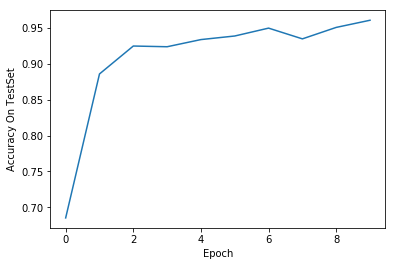

In [16]:
if __name__ == '__main__':
  acc_list_test = []
  for epoch in range(EPOCH):
    train(epoch)
    # if epoch % 10 == 9:  #每训练10轮 测试1次
    acc_test = test()
    acc_list_test.append(acc_test)

  plt.plot(acc_list_test)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy On TestSet')
  plt.show()